# EDA of TalkingData Mobile Usage Data 
Group: Tharun, Sara, Youseff, Goutham, Steven

In [193]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
# set sns style to dark mode
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})



### Loading Data

In [3]:
# PATHS TO FILES
app_events = pd.read_csv('data/app_events.csv')
app_labels = pd.read_csv('data/app_labels.csv')
events = pd.read_csv('data/events.csv')
gender_age_test = pd.read_csv('data/gender_age_test.csv')
gender_age_train = pd.read_csv('data/gender_age_train.csv')
label_categories = pd.read_csv('data/label_categories.csv')
phone_brand = pd.read_csv('data/phone_brand_device_model.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [4]:
print('\napp_events\n', app_events.columns)
print('\napp_labels\n', app_labels.columns)
print('\nevents\n', events.columns)
print('\ngender_age_test\n', gender_age_test.columns)
print('\ngender_age_train\n', gender_age_train.columns)
print('\nlabel_categories\n', label_categories.columns)
print('\nphone_brand\n', phone_brand.columns)
print('\nsample_submission\n', sample_submission.columns)


app_events
 Index(['event_id', 'app_id', 'is_installed', 'is_active'], dtype='object')

app_labels
 Index(['app_id', 'label_id'], dtype='object')

events
 Index(['event_id', 'device_id', 'timestamp', 'longitude', 'latitude'], dtype='object')

gender_age_test
 Index(['device_id'], dtype='object')

gender_age_train
 Index(['device_id', 'gender', 'age', 'group'], dtype='object')

label_categories
 Index(['label_id', 'category'], dtype='object')

phone_brand
 Index(['device_id', 'phone_brand', 'device_model'], dtype='object')

sample_submission
 Index(['device_id', 'F23-', 'F24-26', 'F27-28', 'F29-32', 'F33-42', 'F43+',
       'M22-', 'M23-26', 'M27-28', 'M29-31', 'M32-38', 'M39+'],
      dtype='object')


### Age/Gender Visualizations

/Users/tharun/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of age overall')

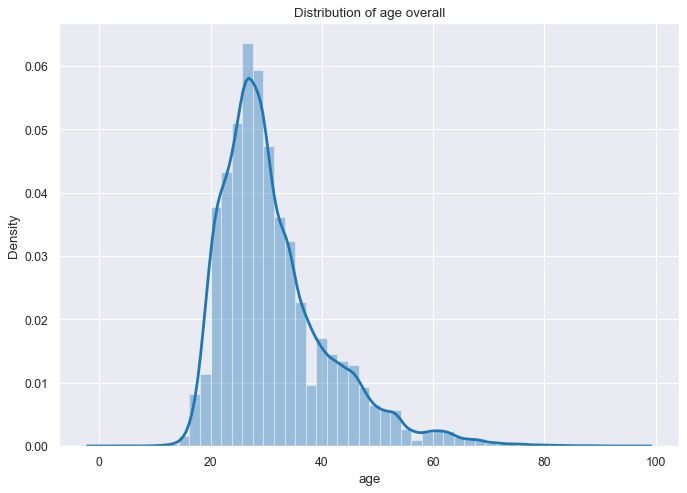

In [5]:
# Distribution of Age in general population
plt.figure(figsize=(10,7), dpi= 80)
# make the opacity of the plot 1
ax = sns.distplot(gender_age_train['age'], bins=50)
plt.title('Distribution of age overall')

Text(0.5, 1.0, 'Distribution of age by gender')

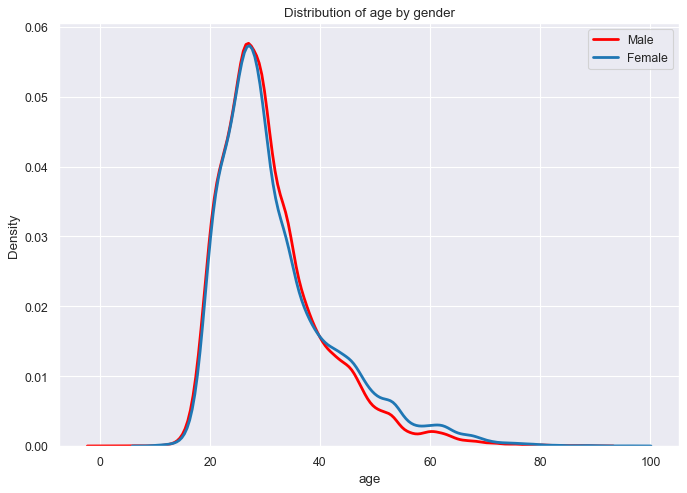

In [6]:
# Distribution of Age by Gender
# ax = sns.displot(gender_age_train, x="age", col="gender", stat="density")
plt.figure(figsize=(10,7), dpi= 80)
male = gender_age_train.loc[gender_age_train.gender=='M', 'age']
female = gender_age_train.loc[gender_age_train.gender=='F', 'age']
ax = sns.kdeplot(male, color='r', label='Male')
ax = sns.kdeplot(female, label='Female')
plt.legend()
plt.title('Distribution of age by gender')

### Visualizing Events

count    60865.000000
mean        53.445330
std        196.650376
min          1.000000
25%          4.000000
50%         15.000000
75%         51.000000
max      33426.000000
Name: freq, dtype: float64

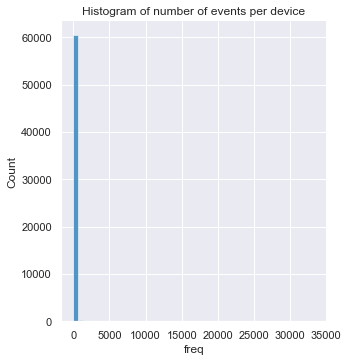

In [254]:
# len(events) = 3252950
# events['device_id'].nunique() = 60865
# There are a lot of events for each device id. Let's get the average/median events per device, lets plot it on a histogram. 
from collections import Counter
events_per_device = Counter(events['device_id'])
events_per_device = pd.DataFrame.from_dict(events_per_device, orient='index', columns=['freq'])
events_per_device = events_per_device.sort_values('freq', ascending=False)
# Plot the histogram
# plt.figure(figsize=(10,7), dpi= 80)
ax = sns.displot(events_per_device['freq'], bins=50)
plt.title("Histogram of number of events per device")
events_per_device['freq'].describe()

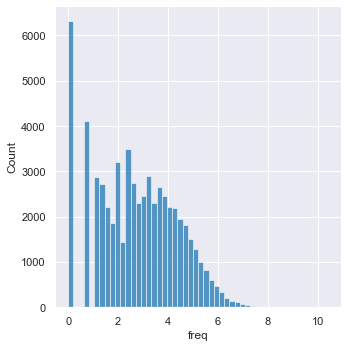

In [253]:
# Since the distribution above is highly skewed, lets plot the log transformatino of the frequency to see more clearly.
ax = sns.displot(np.log(events_per_device['freq']), bins=50)

We can see from the above that there are a few extreme outliers, but the on average there are only about 53 events per device id. 
These outliers may be automated customer service numbers, bots, etc. We should look into eliminating these outliers later, when we're running predictions with a model.

Text(0.5, 1.0, 'Number of events per hour of day')

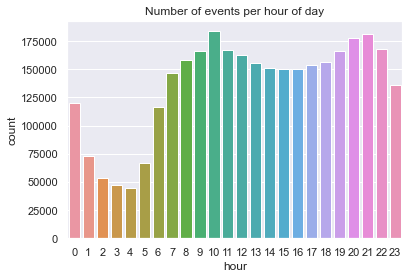

In [245]:
# Plot the timestamp - i.e. a barchart of hourly usage
# i.e. how many events per hour :) 

events['timestamp'] = pd.to_datetime(events['timestamp'])
events['hour'] = events['timestamp'].dt.hour
# print(events['hour'].describe())

ax = sns.countplot(x='hour', data=events)
plt.title('Number of events per hour of day')

The early hours tend to have little activity - might be explained by the fact that most people are asleep at those times. There is also a slight slump in the midday - this is probably because most people are working and spend less time on their phones. We see a spike right after the slump indicating people get back on their phones after ending the workday.

Text(0.5, 1.0, 'Number of events for each day of the week')

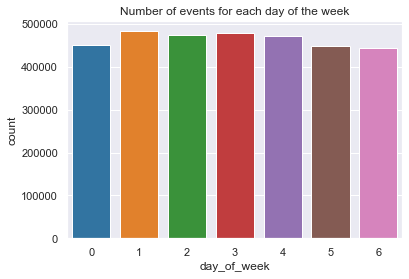

In [248]:
# Lets plot it by day of week
events['day_of_week'] = events['timestamp'].dt.dayofweek
events['day_of_week'] = events['day_of_week'].astype(int)
sns.countplot(x='day_of_week', data=events)
plt.title('Number of events for each day of the week')

A weekly breakdown doesn't seem to reveal much data about the users. Although it is interesting to note slightly reduced usage on the weekends. 

Text(0.5, 1.0, 'Number of events over time')

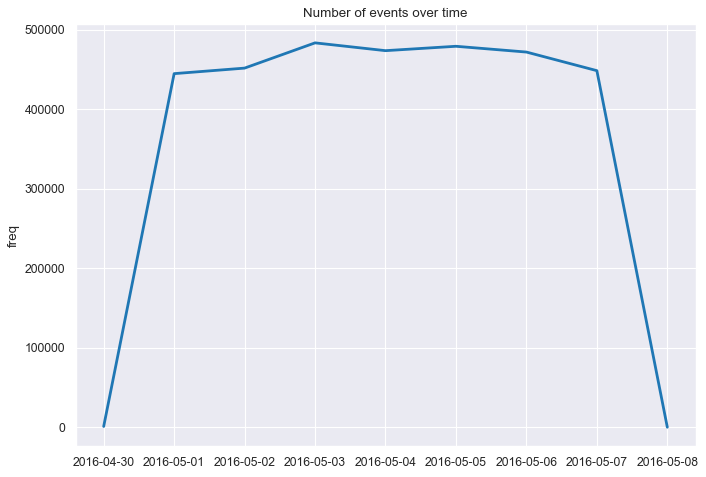

In [249]:
# then also, how many events as time goes on :) 
# First count the unique timestamps in the events dataframe
events['date'] = events['timestamp'].dt.date
events.head()
events_per_day = Counter(events['date'])
events_per_day = pd.DataFrame.from_dict(events_per_day, orient='index', columns=['freq'])
events_per_day.sort_index(inplace=True)
plt.figure(figsize=(10,7), dpi= 80)

# i.e. we make a chart of the number of events over time based on the timestamp
sns.lineplot(x=events_per_day.index, y=events_per_day['freq'])
plt.title('Number of events over time')

Text(0.5, 1.0, 'Location of Events')

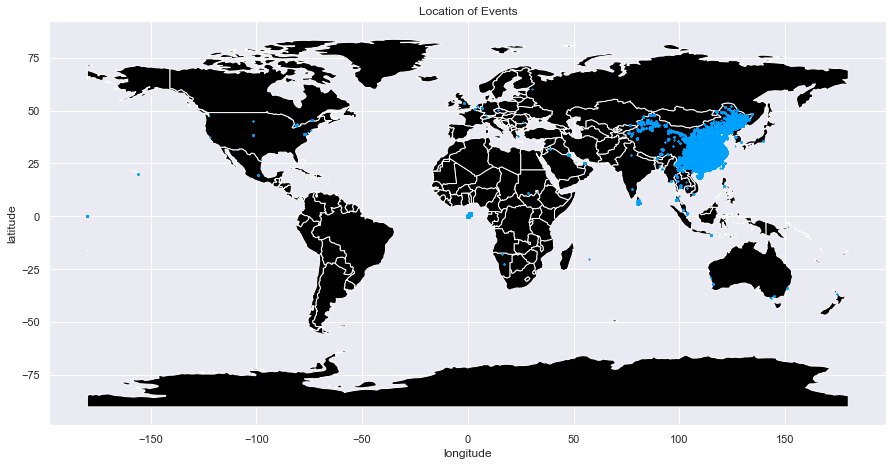

In [11]:
# Plot the longitude and latitude on a world map
import geopandas as gpd
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# increase the size of the plot
fig, ax = plt.subplots(figsize=(15,10))
countries.plot(color="black", ax=ax)
# zoom into the area including China
events.plot(x="longitude", y="latitude", kind="scatter", ax=ax, s=0.5, color="#00a2ff")
plt.title('Location of Events')

The vast majority of the users are within China. A few seem to be outside - perhaps business travellers, tourists or international students. It might be worth to spend more time looking at the differences between those within and outside China.

In [255]:
events_in_china = events[(events.longitude>73) & (events.longitude<135) & (events.latitude>15) & (events.latitude<53)]
print('Number of events within china: ', len(events_in_china))
print('Number of events outside china: ', len(events) - len(events_in_china))

Number of events within china:  2202582
Number of events outside china:  1050368


There seems to be a good amount of activity outside of china (nearly a 3rd of the entire dataset). For now lets focus on within China:

Text(0.5, 1.0, 'Location of ALL Events in China')

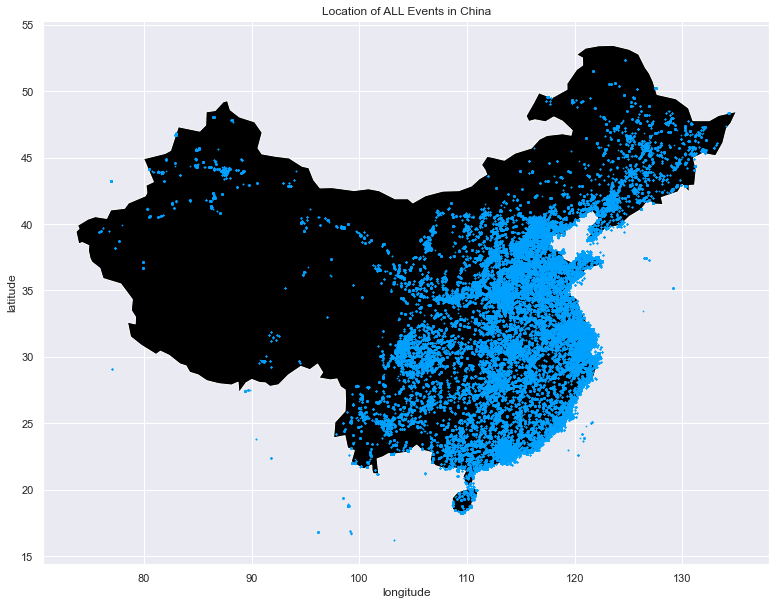

In [256]:
# There are a few data points outside of china, but the vast majority is within china. Lets zoom in and plot for only inside of China.
# select only for the latitude and longitude of the events that are within China
fig, ax = plt.subplots(figsize=(15,10))


# select the countries that are china are russia and india
china = countries[(countries.name=='China')]
china.plot(color="black", ax=ax)
events_in_china.plot(x="longitude", y="latitude", kind="scatter", ax=ax, s=0.5, color="#00a2ff")
plt.title('Location of ALL Events in China')

The initial visualization seems to reflect the general populated locations of China. Perhaps a breakdown by gender/age might reveal more information. Also, note that this visual is for every single event, it might be worth looking at the average location of each device and the corresponding number of events for each device. 

Text(0.5, 1.0, 'Average Location and Frequency of each unique device_id within China')

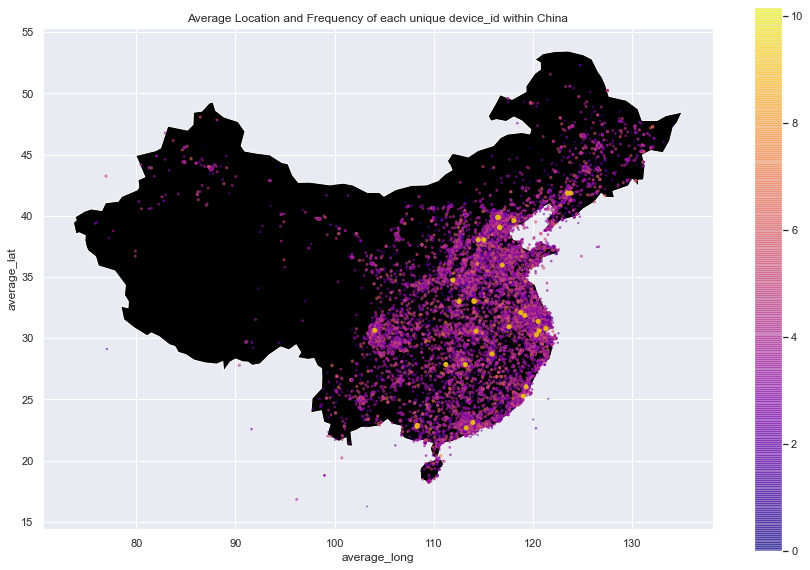

In [306]:
# sort the events by device id 
events_in_china.sort_values('device_id', inplace=True)

# For each device id, get the number of times it occurs in the dataframe
events_in_china_per_device = Counter(events_in_china['device_id'])
events_in_china_per_device = pd.DataFrame.from_dict(events_in_china_per_device, orient='index', columns=['freq'])
events_in_china_per_device.reset_index(inplace=True)
events_in_china_per_device.sort_values('index', inplace=True)

# # now for each unique device id, find the average latitude and longitude
events_in_china['average_lat'] = events_in_china.groupby('device_id')['latitude'].transform('mean')
events_in_china['average_long'] = events_in_china.groupby('device_id')['longitude'].transform('mean')

# # Keep only the unique device ids
unique_chinese_devices = events_in_china.drop_duplicates('device_id')
unique_chinese_devices.sort_values('device_id', inplace=True)
unique_chinese_devices['frequency'] = list(events_in_china_per_device['freq'])

# Now we can plot them on a map, by using the average latitude and longitude and having the size and color of the circle proportional to the frequency of the device id
# The distribution of the frequency is highly skewed, so a log transform will allow us to see it more clearer
unique_chinese_devices['og_freq'] = unique_chinese_devices['frequency']
unique_chinese_devices['frequency'] = unique_chinese_devices['frequency'].apply(lambda x: np.log(x))
# unique_chinese_devices['frequency'] = unique_chinese_devices['frequency']/max(unique_chinese_devices['frequency'])
fig, ax = plt.subplots(figsize=(15,10))
china.plot(color="black", ax=ax)

unique_chinese_devices.plot(x="average_long", y="average_lat", kind="scatter", ax=ax, c=unique_chinese_devices['frequency'], alpha=0.5, colormap="plasma", s=unique_chinese_devices['frequency'])

# Plot the high frequency ones to see the outliers
# high frequency ones are those above the 99.9th percentile
high_freq = unique_chinese_devices[unique_chinese_devices['frequency']>unique_chinese_devices['frequency'].quantile(0.999)]
high_freq.plot(x="average_long", y="average_lat", kind="scatter", ax=ax, s=2*high_freq['frequency'], color="#e6b619")

plt.title('Average Location and Frequency of each unique device_id within China')

There are significant outliers visible here, mostly in the large cities. Otherwise we see that the average activity throughout china doesn't seem to be too different than average. Lets try mapping it again, this time eliminating outliers to see if the relationship with location changes:

<AxesSubplot:xlabel='average_long', ylabel='average_lat'>

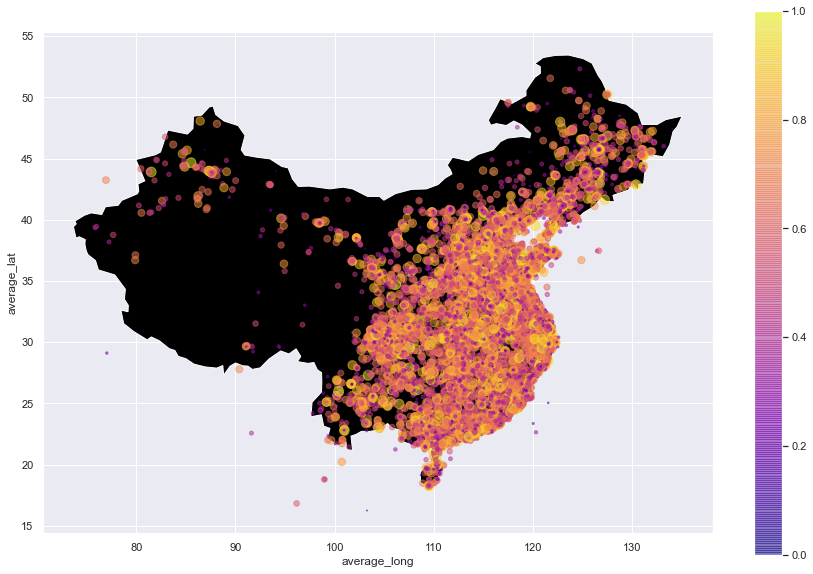

In [327]:
fig, ax = plt.subplots(figsize=(15,10))
china.plot(color="black", ax=ax)

without_outliers = unique_chinese_devices[unique_chinese_devices['og_freq']<unique_chinese_devices['og_freq'].quantile(0.99)]
without_outliers['frequency'] = without_outliers['frequency']/max(without_outliers['frequency'])
without_outliers.plot(x="average_long", y="average_lat", kind="scatter", ax=ax, c=without_outliers['frequency'], alpha=0.5, colormap="plasma", s=(without_outliers['frequency']*10)**2)

This graph has the outliers eliminated, and the original set of frequencies normalized to 0 and 1. The size of the circles increased with power of 2. We see the larger ones seem to be more frequently occuring, showing us a better description of the data without the outliers - true for 99% of the data. Unfortunately we still dont really see any significant changes with geogrpahy compared to the previous one. 

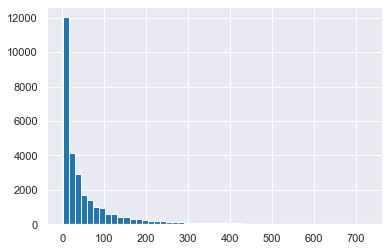

In [328]:
x = plt.hist(without_outliers['og_freq'], bins=50)

Most people produce very few events on average - what are those demographics that produce the highest ones? I don't know if there is an actual correlation there?

### Phone Brand

In [216]:
# Converting what we can to english, but not all
phoneBrandOriginalList = ["三星","天语","海信","联想","欧比","爱派尔",
                           "努比亚","优米","朵唯","黑米","锤子",
                           "酷比魔方","美图","尼比鲁","一加","优购","诺基亚",
                           "糖葫芦","中国移动","语信","基伍","青橙","华硕",
                           "夏新","维图","艾优尼","摩托罗拉","乡米",
                           "米奇","大可乐","沃普丰","神舟","摩乐","飞秒",
                           "米歌","富可视","德赛","梦米","乐视","小杨树",
                           "纽曼","邦华","E派","易派","普耐尔","欧新",
                           "西米","海尔","波导","糯米","唯米","酷珀","谷歌",
                           "昂达","聆韵", '小米', '华为', '魅族', '酷派', '金立', '中兴', '索尼']

phoneBrandEnglishList = ["samsung","ktouch","hisense","lenovo","obi","ipair",
                          "nubia","youmi","dowe","heymi","hammer","koobee",
                          "meitu","nibilu","oneplus","yougo","nokia","candy",
                          "ccmc","yuxin","kiwu","greeno","asus","panosonic",
                          "weitu","aiyouni","moto","xiangmi","micky",
                          "bigcola","wpf","hasse","mole","fs","mige","fks",
                          "desci","mengmi","lshi","smallt","newman","banghua",
                          "epai","epai","pner","ouxin","ximi","haier","bodao",
                          "nuomi","weimi","kupo","google","ada","lingyun", 'xiaomi', 'huawei', 'meizu', 'coolpad', 'gionee', 'zte', 'sony']

# Map the chinese to the english equivalent
phone_brand['phone_brand'] = phone_brand['phone_brand'].replace(phoneBrandOriginalList, phoneBrandEnglishList)

Text(0.5, 1.0, 'Top 25 Phone Brands')

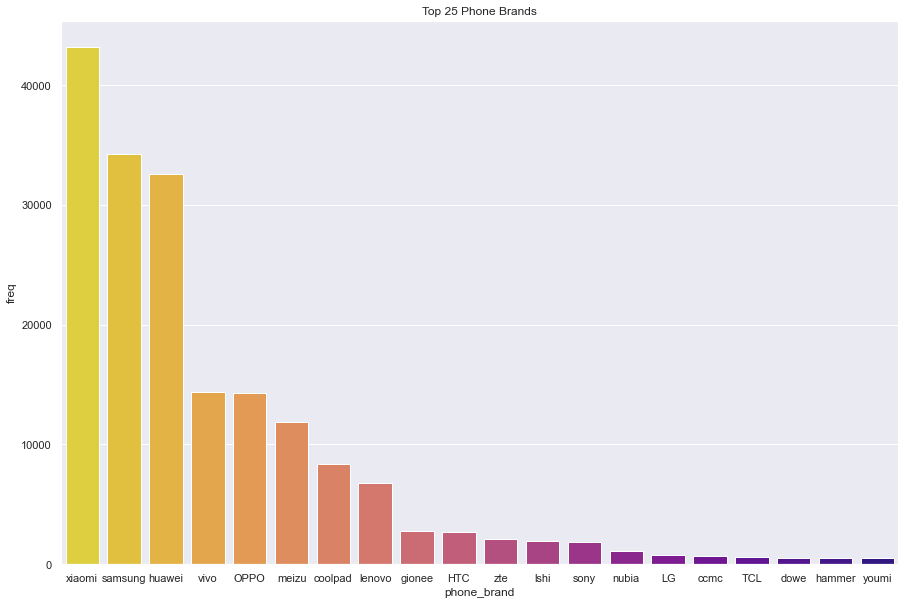

In [239]:
# Count the frequency of each phone brand, and put it in a dataframe with columns 'phone_brand' and 'freq'
fig, ax = plt.subplots(figsize=(15,10))

phone_brand_count = phone_brand['phone_brand'].value_counts()
phone_brand_count = pd.DataFrame.from_dict(phone_brand_count).reset_index()
phone_brand_count.columns = ['phone_brand', 'freq']
sns.barplot(data=phone_brand_count[:20], x='phone_brand', y='freq', ax=ax, palette='plasma_r')
plt.title('Top 25 Phone Brands')

Text(0.5, 1.0, 'Top 25 Device Models')

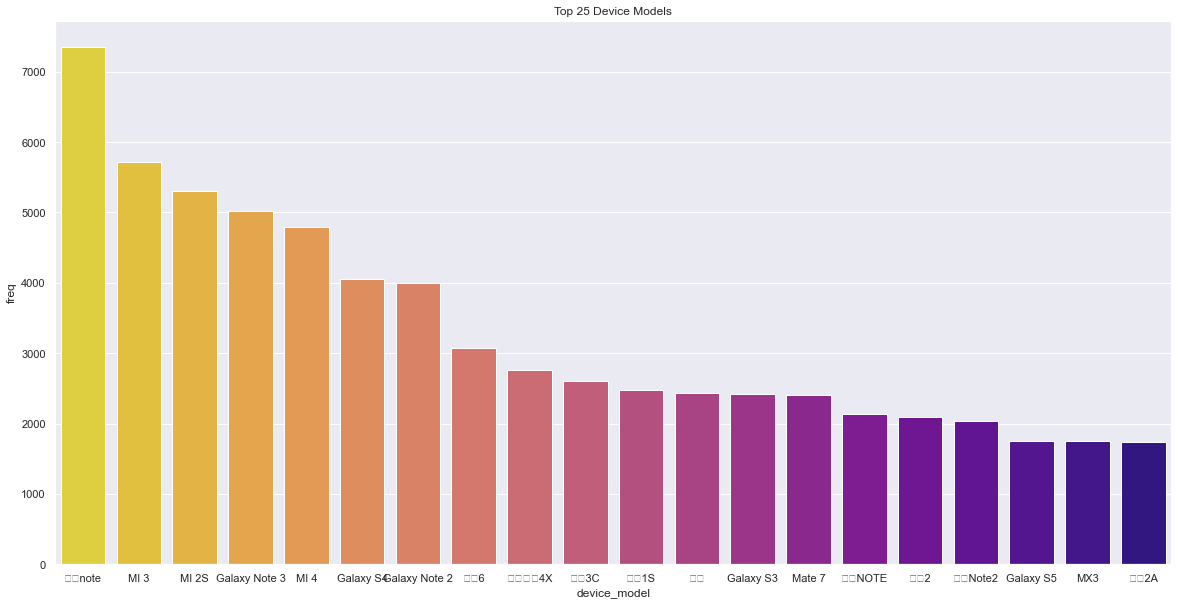

In [240]:
# lets do the same for the top 20 device models
fig, ax = plt.subplots(figsize=(20,10))

device_model_count = phone_brand['device_model'].value_counts()
device_model_count = pd.DataFrame.from_dict(device_model_count).reset_index()
device_model_count.columns = ['device_model', 'freq']
sns.barplot(data=device_model_count[:20], x='device_model', y='freq', ax=ax, palette='plasma_r')
plt.title('Top 25 Device Models')


### Missing Data?

In [336]:
# check if phone brand contains any NaN values

data = {'app_events': app_events,
'app_labels': app_labels,
'events': events,
'gender_age_test': gender_age_test,
'gender_age_train': gender_age_train,
'label_categories': label_categories,
'phone_brand': phone_brand,
'sample_submission': sample_submission}

print('% of NaN data for each Dataset')
for i in data:
    print(i, 100*data[i].isnull().sum().sum()/len(data[i]))

% of NaN data for each Dataset
app_events 0.0
app_labels 0.0
events 0.0
gender_age_test 0.0
gender_age_train 0.0
label_categories 0.3225806451612903
phone_brand 0.0
sample_submission 0.0


### Duplicate Data?

In [338]:
print('% Of Duplicate Data for each dataset')
for i in data:
    # check how many duplicate rows there are for each dataframe
    print(i, 100*data[i].duplicated().sum()/len(data[i]))

% Of Duplicate Data for each dataset
app_events 0.0
app_labels 0.10675235844441594
events 0.0
gender_age_test 0.0
gender_age_train 0.0
label_categories 0.0
phone_brand 0.27931319928436005
sample_submission 0.0


## What next
- maybe there is correlation between usage by hour and gender and age.
- what sorts of bias will our prediction model produce? The dataset seems significantly skewed towards those who are in their 20s - perhaps we might need to stratify the training data to accommodate this?
- There might also be an age related difference in terms of location - more rural parts may have an elderly population. This might be a useful point for feature engineering. 
- Further identify how events within china and outside of china differ either by age, phone models, gender, hourly usage, etc. 